In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# ANÁLISIS EXPLORATORIO SOBRE EL CONJUNTO DE DATOS

## Estructura y tipo de las imagenes

Nombre imagen: dog.3511.jpg
Dimensiones de la imagen:
(500, 366, 3)


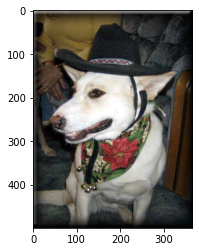

Nombre imagen: cat.3132.jpg
Dimensiones de la imagen:
(450, 500, 3)


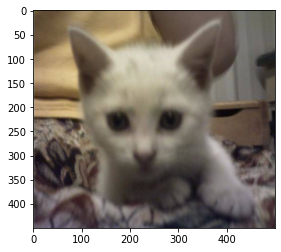

Nombre imagen: dog.1580.jpg
Dimensiones de la imagen:
(300, 299, 3)


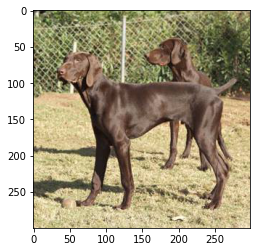

Nombre imagen: cat.2038.jpg
Dimensiones de la imagen:
(375, 499, 3)


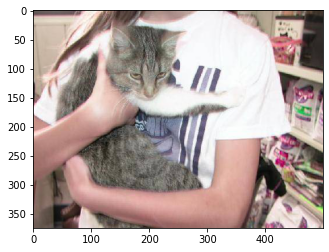

Nombre imagen: dog.2260.jpg
Dimensiones de la imagen:
(331, 500, 3)


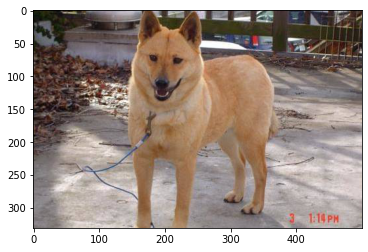

Nombre imagen: cat.178.jpg
Dimensiones de la imagen:
(347, 459, 3)


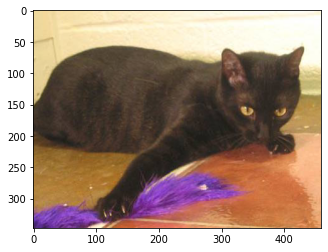

In [3]:
from skimage import io
from random import randint

for x in range(3):
    
    nro_imagen_dog = randint(0,4000)
    nro_imagen_cat = randint(0,4000)
    image_dog=io.imread("./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
    image_cat=io.imread("./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))

    print("Nombre imagen: dog."+ str(nro_imagen_dog) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_dog.shape)
    plt.imshow(image_dog)
    plt.show()
    
    print("Nombre imagen: cat."+ str(nro_imagen_cat) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_cat.shape)
    plt.imshow(image_cat)
    
    plt.show()

## Volumetría de datos

In [4]:
animales = "cats", "dogs"

# Directorio de imágenes
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set/test_set')

In [7]:
train = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=animales,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(128, 128),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=47,  # semilla para que la aleatoriedad sea repetible
)

Found 8005 files belonging to 2 classes.


In [8]:
test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=animales,
    color_mode="rgb",
    image_size=(128, 128),
    shuffle=True,
    seed=47,
)

Found 2023 files belonging to 2 classes.


In [9]:
def sample_images(dataset):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(animales[np.argmax(labels[i])])
            plt.axis("off")

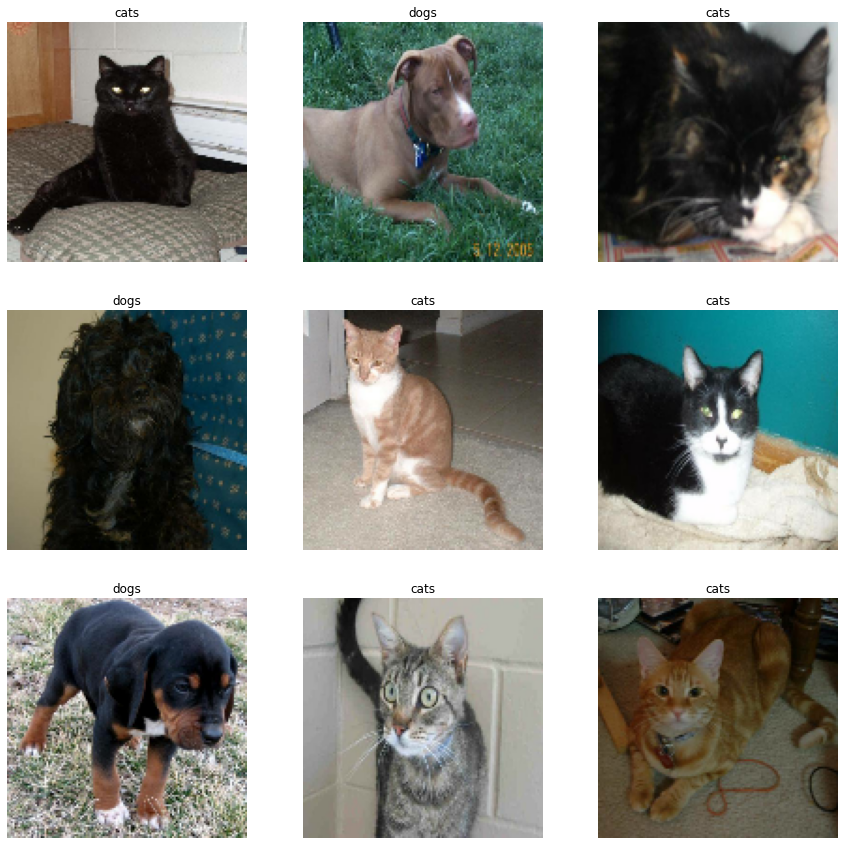

In [10]:
sample_images(train)

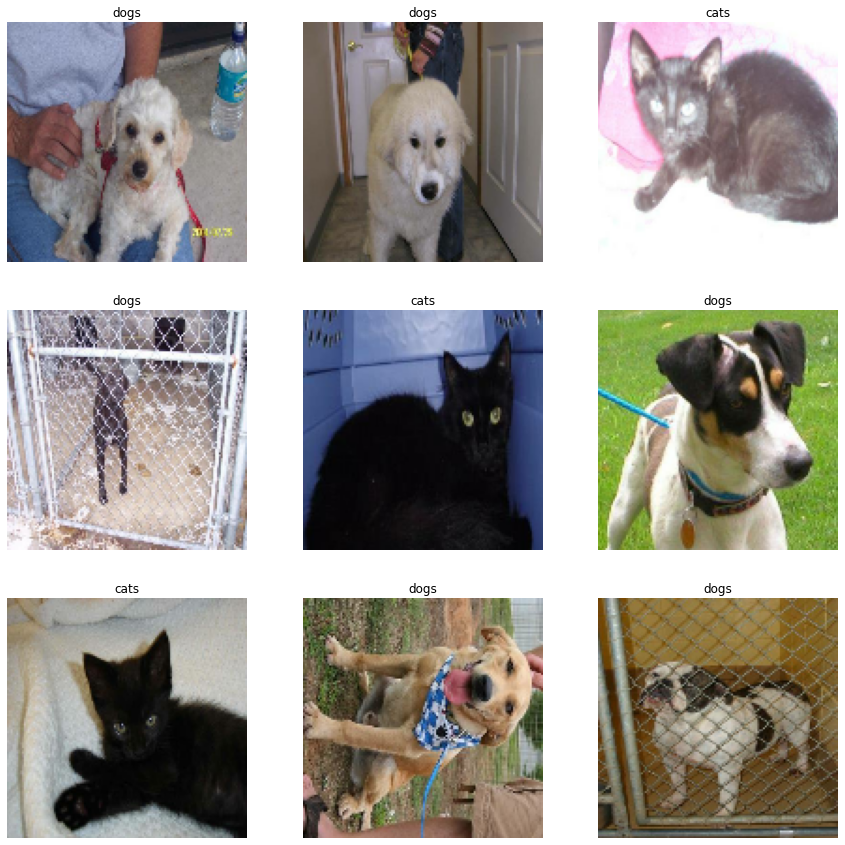

In [11]:
sample_images(test)

## Distribución de la variable a predecir

# MACHINE LEARNING

## Funciones útiles

In [12]:
# Función para predecir

from IPython.display import Image, display

def show_and_predict(model,image_path):
    image_array = img_to_array(load_img(image_path, target_size=(128, 128)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", animales[np.argmax(predictions)])
    print("Prediction detail:", predictions)

In [13]:
# Función que dibuja la matriz de confusión
def matriz(model):
    
    datasets = (
        ("train", train),
        ("test", test),   
    )

    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        # el dataset se itera en batches, así que calculamos predicciones y labels por cada batch, y luego 
        # concatenamos todo
        batches_predictions = []
        batches_labels =  []

        for batch_images, batch_labels in dataset:
            # super importante: usamos argmax para convertir cosas de este formato:
            # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
            # a este formato (donde tenemos el índice de la clase que tiene número más alto):
            # [1, 0, 0, 2]
            batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
            batches_labels.append(np.argmax(batch_labels, axis=-1))

        predictions = np.concatenate(batches_predictions)
        labels = np.concatenate(batches_labels)

        print('accuracy', accuracy_score(labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))

        plt.xticks([0, 1], animales, rotation=45)
        plt.yticks([0, 1], animales)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

In [14]:
# Función que dibuja las curvas
def curvas(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

## Modelos

### MLP 1

In [59]:
model_mlp_1 = Sequential([
    
    Rescaling(1/255, input_shape=(128, 128, 3)), # normalizar las entradas de los datasets
    
    Flatten(),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [60]:
model_mlp_1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 49152)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 10)                491530    
_________________________________________________________________
dropout_57 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_58 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 2)               

In [61]:
history_mlp_1 = model_mlp_1.fit(
    train,
    epochs=5,
    batch_size=128, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 29s 112ms/step - loss: 0.7651 - accuracy: 0.5138 - val_loss: 0.6941 - val_accuracy: 0.5002
Epoch 2/5
251/251 [==============================] - 32s 125ms/step - loss: 0.7390 - accuracy: 0.4967 - val_loss: 0.6933 - val_accuracy: 0.5002
Epoch 3/5
251/251 [==============================] - 28s 110ms/step - loss: 0.7146 - accuracy: 0.5056 - val_loss: 0.6941 - val_accuracy: 0.5002
Epoch 4/5
251/251 [==============================] - 33s 131ms/step - loss: 0.7060 - accuracy: 0.5077 - val_loss: 0.6933 - val_accuracy: 0.5002
Epoch 5/5
251/251 [==============================] - 33s 131ms/step - loss: 0.7016 - accuracy: 0.4970 - val_loss: 0.6934 - val_accuracy: 0.5002


######################### train #########################
accuracy 0.5003123048094941


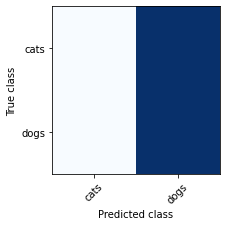

######################### test #########################
accuracy 0.5002471576866041


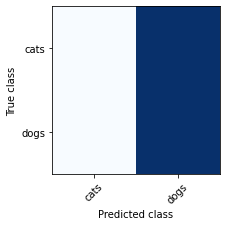

In [62]:
matriz(model_mlp_1)

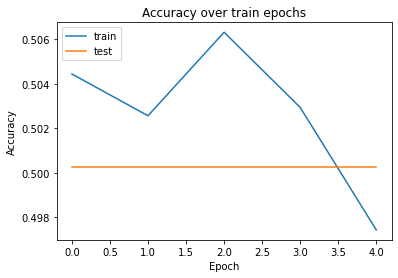

In [63]:
curvas(history_mlp_1)

### MLP 2

In [33]:
model_mlp_2 = Sequential([
    
    Rescaling(1/255, input_shape=(128, 128, 3)), # normalizar las entradas de los datasets

    Flatten(),
    
    Dense(10, activation='relu'),
    Dropout(0.1),
    
    Dense(10, activation='relu'),

    Dense(10, activation='relu'),
    Dropout(0.1),
    
    Dense(20, activation='relu'),
    
    Dense(10, activation='relu'),
    Dropout(0.2),
    
    Dense(10, activation='relu'),
    
    Dense(10, activation='relu'),
    Dropout(0.2),
    
    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [34]:
history_mlp_2 = model_mlp_2.fit(
    train,
    epochs=10,
    batch_size=128, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 29s 108ms/step - loss: 0.7017 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 2/10
251/251 [==============================] - 25s 99ms/step - loss: 0.6932 - accuracy: 0.4840 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 3/10
251/251 [==============================] - 27s 106ms/step - loss: 0.6932 - accuracy: 0.4884 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 4/10
251/251 [==============================] - 25s 96ms/step - loss: 0.6932 - accuracy: 0.4877 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 5/10
251/251 [==============================] - 25s 98ms/step - loss: 0.6933 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 6/10
251/251 [==============================] - 25s 99ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 7/10
251/251 [==============================] - 25s 99ms/step - loss: 0.6932 - accuracy: 0.4938 - val_loss: 0.6931 - val_accurac

######################### train #########################
accuracy 0.5003123048094941


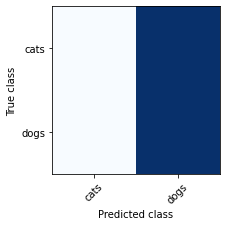

######################### test #########################
accuracy 0.5002471576866041


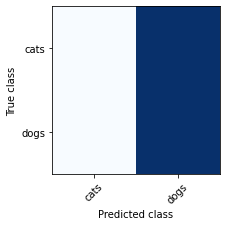

In [35]:
matriz(model_mlp_2)

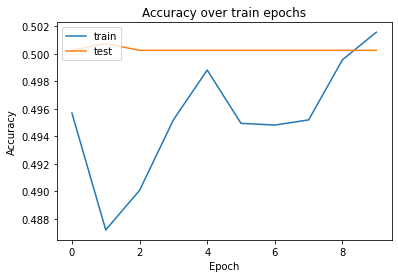

In [36]:
curvas(history_mlp_2)

### CONVOLUCIONAL 1

In [20]:
model_cnn1 = Sequential([

    Rescaling(1/255, input_shape=(128, 128, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x3, y salida de 125x125x8
    Dropout(0.2),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 122x122x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 30x30x8
    
    Flatten(),
    # salida de 7200
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [21]:
model_cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 8)       392       
_________________________________________________________________
dropout_2 (Dropout)          (None, 125, 125, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 8)       1032      
_________________________________________________________________
dropout_3 (Dropout)          (None, 122, 122, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)             

In [22]:
history_cnn1 = model_cnn1.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 414s 2s/step - loss: 0.7185 - accuracy: 0.5509 - val_loss: 0.6340 - val_accuracy: 0.6401
Epoch 2/5
251/251 [==============================] - 272s 1s/step - loss: 0.6425 - accuracy: 0.6324 - val_loss: 0.6273 - val_accuracy: 0.6520
Epoch 3/5
251/251 [==============================] - 261s 1s/step - loss: 0.5767 - accuracy: 0.7095 - val_loss: 0.6162 - val_accuracy: 0.6560
Epoch 4/5
251/251 [==============================] - 250s 995ms/step - loss: 0.5499 - accuracy: 0.7271 - val_loss: 0.6041 - val_accuracy: 0.6678
Epoch 5/5
251/251 [==============================] - 262s 1s/step - loss: 0.5173 - accuracy: 0.7608 - val_loss: 0.5832 - val_accuracy: 0.6886


######################### train #########################
accuracy 0.779262960649594


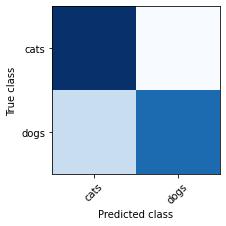

######################### test #########################
accuracy 0.6885813148788927


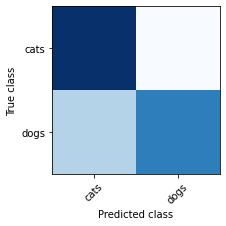

In [23]:
matriz(model_cnn1)

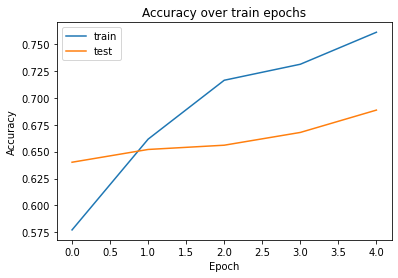

In [24]:
curvas(history_cnn1)

### CONVOLUCIONAL 2

In [51]:
model_cnn2 = Sequential([

    Rescaling(1/255, input_shape=(128, 128, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='tanh'),
    # kernels de 4x4x3, y salida de 125x125x8
    Dropout(0.1),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 122x122x8
    Dropout(0.1),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 30x30x8
    
    Flatten(),
    # salida de 7200
    
    Dense(15, activation='relu'),
    # salida de 10
    Dropout(0.2),
    
    Dense(15, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [52]:
model_cnn2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 125, 125, 8)       392       
_________________________________________________________________
dropout_50 (Dropout)         (None, 125, 125, 8)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 122, 122, 8)       1032      
_________________________________________________________________
dropout_51 (Dropout)         (None, 122, 122, 8)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 7200)            

In [53]:
history_cnn2 = model_cnn2.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 284s 1s/step - loss: 0.7014 - accuracy: 0.5205 - val_loss: 0.6682 - val_accuracy: 0.6041
Epoch 2/10
251/251 [==============================] - 278s 1s/step - loss: 0.6595 - accuracy: 0.6060 - val_loss: 0.5809 - val_accuracy: 0.6990
Epoch 3/10
251/251 [==============================] - 279s 1s/step - loss: 0.5856 - accuracy: 0.7031 - val_loss: 0.5349 - val_accuracy: 0.7217
Epoch 4/10
251/251 [==============================] - 279s 1s/step - loss: 0.5298 - accuracy: 0.7394 - val_loss: 0.5754 - val_accuracy: 0.7187
Epoch 5/10
251/251 [==============================] - 281s 1s/step - loss: 0.4853 - accuracy: 0.7750 - val_loss: 0.5498 - val_accuracy: 0.7395
Epoch 6/10
251/251 [==============================] - 282s 1s/step - loss: 0.4706 - accuracy: 0.7847 - val_loss: 0.5878 - val_accuracy: 0.7291
Epoch 7/10
251/251 [==============================] - 280s 1s/step - loss: 0.4373 - accuracy: 0.8021 - val_loss: 0.5998 - val_accuracy: 0.7365

######################### train #########################
accuracy 0.8712054965646471


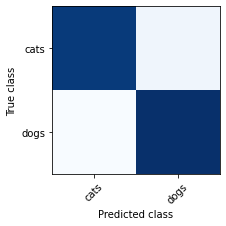

######################### test #########################
accuracy 0.7226890756302521


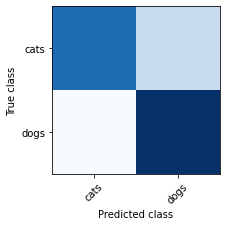

In [54]:
matriz(model_cnn2)

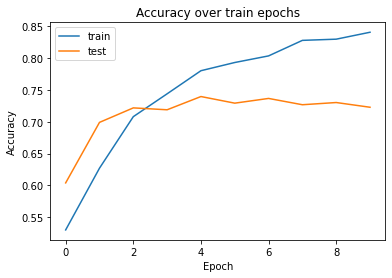

In [55]:
curvas(history_cnn2)

### Red Convolucional elegida: Ejemplos

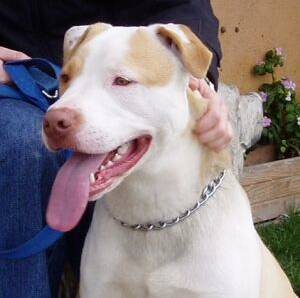

Prediction: dogs
Prediction detail: [[0.0439625 0.9560375]]


In [64]:
show_and_predict(model_cnn1,"/home/migue/Escritorio/MachineLearning/imagenes_tp3_cv/test_set/test_set/dogs/dog.4089.jpg")

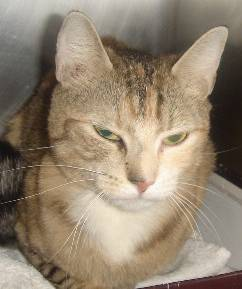

Prediction: cats
Prediction detail: [[0.97793055 0.02206946]]


In [68]:
show_and_predict(model_cnn2,"/home/migue/Escritorio/MachineLearning/imagenes_tp3_cv/test_set/test_set/cats/cat.4290.jpg")